In [1]:
#imports

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# gloabl params for all matplotlib plots
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
zip_path = tf.keras.utils.get_file( 
    origin='http://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip',

    fname='household_power_consumption.zip',
    extract=True)

print(zip_path)

20640916/20640916 [==============================] - 0s 0us/step
/root/.keras/datasets/household_power_consumption.zip


In [4]:
csv_path, _ = os.path.splitext(zip_path) 
print(csv_path)

/root/.keras/datasets/household_power_consumption


In [5]:
df = pd.read_csv('/root/.keras/datasets/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'],index_col='dt')

In [6]:
#checking for missing values
df.columns[df.isnull().any()]

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [7]:
#removing missing values
df=df.interpolate(method ='linear', limit_direction ='forward')

In [8]:
df.columns[df.isnull().any()]

Index([], dtype='object')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7feadaec3390>,
      dtype=object)

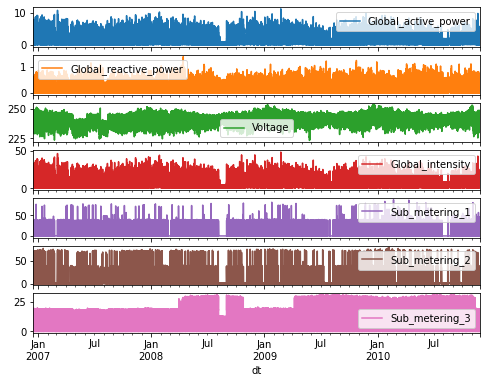

In [9]:
df.plot(subplots=True)

In [10]:
#lets only use 3 features for prediction, remember we can use any no of features
df=df[['Global_active_power','Global_reactive_power','Global_intensity']]

In [12]:
train_split = 1800000  

multi_step = df.values
data_mean = multi_step[:train_split].mean(axis=0)
data_std = multi_step[:train_split].std(axis=0)

multi_step= (multi_step-data_mean)/data_std

In [11]:
#defining a function to get our data in multi variate data
# Same as univariate_data above.

# New params:
# step: instead of taking data for each 1min as in pur data, we can say we want to use 1 reading every 10 min
# single_step: lables from single timestamp or multiple timesteps


def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step) # step used here.
    data.append(dataset[indices])

    if single_step: # single_step used here.
      labels.append(target[i+target_size]) 
    else:
      labels.append(target[i:i+target_size]) 

  return np.array(data), np.array(labels)

In [13]:
#for multi step we dont pass single=true , future target is that we 30 values sequence in future
# Generate data
train_split=1500000
test_split=1800000

past_history = 300  #(say we want to consider history of last 5 hours so past history is 5 X 60)
future_target = 30   # say we want 30 values sequence in future
STEP = 6  # one obs every 6 min  (instead of taking data for each 1min as in pur data, we can say we want to use 1 reading every 6  min)





x_train_step, y_train_step = multivariate_data(multi_step, multi_step[:, 1], 0,
                                                   train_split, past_history,
                                                   future_target, STEP,
                                                   )
x_val_step, y_val_step = multivariate_data(multi_step,multi_step[:, 1],
                                               train_split, test_split, past_history,
                                               future_target, STEP,
                                               )

x_test_step, y_test_step = multivariate_data(multi_step,multi_step[:, 1],
                                               test_split, None, past_history,
                                               future_target, STEP,
                                               )

print(x_train_step.shape)
print(y_train_step.shape)
print(x_val_step.shape)
print(y_val_step.shape)
print(x_test_step.shape)
print(y_test_step.shape)


(1499700, 50, 3)
(1499700, 30)
(299700, 50, 3)
(299700, 30)
(274929, 50, 3)
(274929, 30)


Notice we 30 dimensions in our y

In [15]:
BATCH_SIZE = 256 # bacth size in batch-SGD/variants
BUFFER_SIZE = 10000 # for shuffling the dataset

train_multivariate = tf.data.Dataset.from_tensor_slices((x_train_step, y_train_step))
train_multivariate = train_multivariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat

val_multivariate = tf.data.Dataset.from_tensor_slices((x_val_step, y_val_step))
val_multivariate = val_multivariate.batch(BATCH_SIZE).repeat()


test_multivariate = tf.data.Dataset.from_tensor_slices((x_test_step, y_test_step))
test_multivariate = test_multivariate.batch(BATCH_SIZE)

In [19]:
# Model
STEPS_PER_EPOCH = 200
EPOCHS = 10
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_step.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(30)) # for 30 outputs

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_history = multi_step_model.fit(train_multivariate, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_multivariate,
                                          validation_steps=50)


Epoch 1/10
200/200 [==============================] - 18s 69ms/step - loss: 0.8158 - val_loss: 0.8318
Epoch 2/10
200/200 [==============================] - 11s 53ms/step - loss: 0.7381 - val_loss: 0.7990
Epoch 3/10
200/200 [==============================] - 13s 66ms/step - loss: 0.6552 - val_loss: 0.7923
Epoch 4/10
200/200 [==============================] - 10s 52ms/step - loss: 0.5579 - val_loss: 0.7999
Epoch 5/10
200/200 [==============================] - 10s 51ms/step - loss: 0.5940 - val_loss: 0.9191
Epoch 6/10
200/200 [==============================] - 10s 51ms/step - loss: 0.6540 - val_loss: 0.8729
Epoch 7/10
200/200 [==============================] - 10s 51ms/step - loss: 0.5244 - val_loss: 0.8258
Epoch 8/10
200/200 [==============================] - 10s 52ms/step - loss: 0.5687 - val_loss: 0.8695
Epoch 9/10
200/200 [==============================] - 10s 52ms/step - loss: 0.5180 - val_loss: 0.8666
Epoch 10/10
200/200 [==============================] - 12s 61ms/step - loss: 0.521

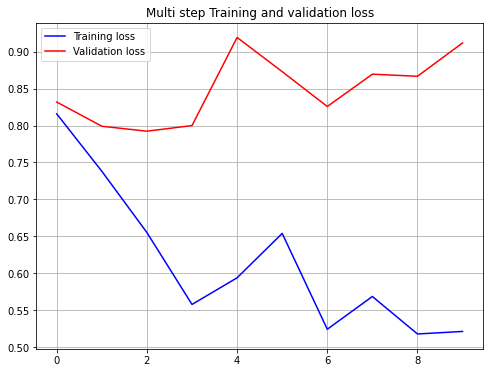

<Figure size 576x432 with 0 Axes>

In [20]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.grid()

  plt.show()



plot_train_history(multi_step_history,
                   'Multi step Training and validation loss')
plt.savefig('file2.png',dpi=300)

In [22]:
print("Evaluate")
result = multi_step_model.evaluate(test_multivariate)
print(result)

Evaluate
1074/1074 [==============================] - 22s 20ms/step - loss: 0.7598
0.7598057985305786
